In [216]:
import numpy as np
import pprint as pp
from matplotlib import pyplot as plt
import shutil
import os
import copy
from typing import List, Tuple, Dict, Any
from IPython.display import clear_output
import time

In [217]:
FILENAME = 'kroA100.tsp'
VISUALIZE = False

In [218]:

def read_data_file(file_name: str) -> Dict[Any, Any]:
    tsp_data = {}
    with open(FILENAME, 'r') as file:
        for line in file:
            if line.startswith('EOF'):
                break
            if line.startswith('DIMENSION'):
                tsp_data['DIMENSION'] = int(line.split()[1])
            parts = line.split()
            if parts[0].isdigit():
                node, x, y = map(int, parts)
                tsp_data[node] = (x, y)

    return tsp_data

def calculate_distance_matrix(tsp_data: Dict[Any, Any]) -> np.ndarray:
    N = tsp_data['DIMENSION']
    tsp_data.pop('DIMENSION')

    distance_matrix = [[0 for _ in range(N + 1)] for _ in range(N + 1)]
    for node in tsp_data:
        x1, y1 = tsp_data[node]
        for other_node in tsp_data:
            if node == other_node:
                continue
            else:
                x2, y2 = tsp_data[other_node]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                distance_matrix[node][other_node] = distance
                distance_matrix[other_node][node] = distance
    return np.array(distance_matrix)

def print_distance_matrix(distance_matrix: np.ndarray):
    print(distance_matrix)

In [219]:
data = read_data_file('kroA100.tsp')
distance = calculate_distance_matrix(data)
print_distance_matrix(distance)

[[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.        ]
 [   0.            0.         2606.92941983  548.51253404 2009.49446379
  1367.89071201 2233.32039797 1130.63035516  580.67977406  515.19704968
   582.06872446  721.50190575  262.86498436 2790.40946816 2301.45975416
  2489.7654508  2438.90180204 2948.68784377 2589.15372274 3007.5787604
   783.17111796]
 [   0.         2606.92941983    0.         3153.61966635 1013.45202156
  3182.53766671  932.0713492  1479.72159544 3056.21105292 2096.84644168
  2886.16510269 3328.10156095 2435.42706727  183.96738841  411.69163217
   881.85089443  236.10379074  510.9256306   522.55143288  882.33610376
  2273.83948422]
 [   0.          548.51253404 3153.61966635    0.         2514.87773063
  1413.26607544 2738.52113375 1678.96426406  3

In [220]:
def plot_cities(data: Dict[Any, Any]) -> None:
    x = []
    y = []
    for city in data:
        x.append(data[city][0])
        y.append(data[city][1])
    plt.scatter(x, y)
    plt.show()


def plot_cycles(cycle1: List, cycle2: List, tsp_data: Dict[Any, Any]) -> None:
    plt.figure(figsize=(8, 6))

    for city in cycle1:
        plt.scatter(tsp_data[city][0], tsp_data[city][1], color='red', s=30)
        plt.text(tsp_data[city][0], tsp_data[city][1], str(city), fontsize=8, ha='left', va='bottom')

    cycle1_x = [tsp_data[city][0] for city in cycle1]
    cycle1_y = [tsp_data[city][1] for city in cycle1]
    cycle1_x.append(cycle1_x[0])
    cycle1_y.append(cycle1_y[0])
    plt.plot(cycle1_x, cycle1_y, linestyle='-', color='blue', label='Cycle 1')

    for city in cycle2:
        plt.scatter(tsp_data[city][0], tsp_data[city][1], color='red', s=30)
        plt.text(tsp_data[city][0], tsp_data[city][1], str(city), fontsize=8, ha='left', va='bottom')

    cycle2_x = [tsp_data[city][0] for city in cycle2]
    cycle2_y = [tsp_data[city][1] for city in cycle2]
    cycle2_x.append(cycle2_x[0])
    cycle2_y.append(cycle2_y[0])
    plt.plot(cycle2_x, cycle2_y, linestyle='-', color='green', label='Cycle 2')

    plt.title('Visualization of Cycles')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.legend()
    plt.savefig('cycles_visualization.png')
    plt.show()


In [221]:
def get_nodes(tsp_data: Dict[Any, Any]) -> np.ndarray:
    nodes = []
    for node in tsp_data:
        if node != 'DIMENSION':
            nodes.append(node)
    return np.array(nodes)

In [222]:
get_nodes(data)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [223]:
def random_cycle(nodes) -> Tuple[np.ndarray, np.ndarray]:
    nodes = copy.deepcopy(nodes)
    np.random.shuffle(nodes)
    half = len(nodes) // 2
    cycle1 = np.array(nodes[:half])
    cycle2 = np.array(nodes[half:])
    
    return cycle1, cycle2

In [224]:
def swap_nodes_between_cycles(cycle1: List, cycle2: List, a_index: int, b_index: int) -> Tuple[np.ndarray, np.ndarray]:
    # cycle1 = copy.deepcopy(cycle1)
    # cycle2 = copy.deepcopy(cycle2)

    tmp = cycle2[b_index]
    cycle2[b_index] = cycle1[a_index]
    cycle1[a_index] = tmp

    return cycle1, cycle2


def swap_edge_within_cycle(cycle: List, a_index: int, b_index: int) -> List:
    # cycle = copy.deepcopy(cycle)
    
    b_index = (b_index + 1) % (len(cycle) + 1)
    if a_index > b_index:
        a_index, b_index = b_index, a_index
    cycle[a_index:b_index] = cycle[a_index:b_index][::-1]
    return cycle

In [225]:
SWAP_NODES_BETWEEN = 2
SWAP_EDGES_WITHIN_CYCLE_1 = 0
SWAP_EDGES_WITHIN_CYCLE_2 = 1

def generate_moves(cycle: List):

    moves = []
    N = len(cycle)

    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_1, (j, k)))

    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_2, (j, k)))

    # generate nodes
    for i in range(N):
        for j in range(N):
                moves.append((SWAP_NODES_BETWEEN, (i, j)))
    
    # shuffle moves
    np.random.shuffle(moves)
    return moves

In [226]:
def apply_move(move: Tuple[int, Tuple[int, int]], cycle1: List, cycle2: List) -> Tuple[List, List]:
    move_type, (a, b) = move
    
    if move_type == SWAP_NODES_BETWEEN:
        cycle1, cycle2 = swap_nodes_between_cycles(cycle1, cycle2, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_1:
        cycle1 = swap_edge_within_cycle(cycle1, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_2:
        cycle2 = swap_edge_within_cycle(cycle2, a, b)

    return cycle1, cycle2

In [227]:
def calculate_cycles_length(cycle1: List, cycle2: List, distance_matrix: np.ndarray) -> float:
    c = [cycle1, cycle2]
    total_length = 0
    for cycle in c:
        length = 0
        for i in range(len(cycle)):
            length += distance_matrix[cycle[i-1]][cycle[i]]
        total_length += length

    return total_length

In [228]:
def rank_move(move, cycle1, cycle2):
    subdistance_before = 0
    subdistance_after = 0

    move_type, (A, B) = move

    if move_type == SWAP_NODES_BETWEEN:
        a = cycle1[A]
        b = cycle2[B]

        a_prev = cycle1[(A-1) % len(cycle1)]
        a_next = cycle1[(A+1) % len(cycle1)]

        b_prev = cycle2[(B-1) % len(cycle2)]
        b_next = cycle2[(B+1) % len(cycle2)]

        subdistance_before += distance[a_prev][a] + distance[a][a_next] + distance[b_prev][b] + distance[b][b_next]
        subdistance_after += distance[a_prev][b] + distance[b][a_next] + distance[b_prev][a] + distance[a][b_next]

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_1:
        a = cycle1[A]
        b = cycle1[B]

        a_prev = cycle1[(A-1) % len(cycle1)]
        b_next = cycle1[(B+1) % len(cycle1)]

        subdistance_before += distance[a_prev][a] + distance[b][b_next]
        subdistance_after += distance[a_prev][b] + distance[a][b_next]

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_2:

        a = cycle2[A]
        b = cycle2[B]

        a_prev = cycle2[(A-1) % len(cycle2)]
        b_next = cycle2[(B+1) % len(cycle2)]

        subdistance_before += distance[a_prev][a] + distance[b][b_next]
        subdistance_after += distance[a_prev][b] + distance[a][b_next]

    return subdistance_after - subdistance_before

In [229]:
def local_search_steepest(cycle1, cycle2, distance):

    moves = generate_moves(cycle1)

    while True:

        best_move = None
        best_delta = 0

        for move in moves:

            delta = rank_move(move, cycle1, cycle2)
            if delta < best_delta:
                best_move = move
                best_delta = delta
                
        if best_delta < 0:
            cycle1, cycle2 = apply_move(best_move, cycle1, cycle2)
            if VISUALIZE:
                clear_output(wait=True)
                plot_cycles(cycle1, cycle2, data)
        elif best_move is None:
            break

    return cycle1, cycle2


In [230]:
# random_cycle1, random_cycle2 = random_cycle(get_nodes(data))

# print(calculate_cycles_length(random_cycle1, random_cycle2, distance))
# plot_cycles(random_cycle1, random_cycle2, data)

In [231]:
# c1, c2 = local_search_steepest(random_cycle1, random_cycle2, distance)
# plot_cycles(c1, c2, data)
# calculate_cycles_length(c1, c2, distance)

In [233]:
def find_city(cycle1, cycle2, node):
    out = np.where(cycle1 == node)[0]
    if len(out) == 1:
        return (True, out[0])
    else:
        return (False, np.where(cycle2 == node)[0][0])

In [234]:
def compute_k_closest_neighbours(distance, k):
    dist = distance[1:, 1:]
    closest = np.argpartition(dist, k+1, axis=1)[:, :k+1] + 1
    zeros = np.zeros(len(closest[0]), dtype=np.uint16)
    return np.concatenate(([zeros], closest))

def find_city(cycle1, cycle2, node):
    out = np.where(cycle1 == node)[0]
    if len(out) == 1:
        return (True, out[0])
    else:
        return (False, np.where(cycle2 == node)[0][0])

def candidate_moves_algorithm(cycle1, cycle2, distance, k=10):
    closest = compute_k_closest_neighbours(distance, k)
    num_cities = len(get_nodes(data))
    iter = 0

    while True:
        best_move = None
        best_delta = 0

        for i in range(1, num_cities+1):
            for j in closest[i]:
                if i==j:
                    continue
                i_in_cycle1, pos_i = find_city(cycle1, cycle2, i)
                j_in_cycle1, pos_j = find_city(cycle1, cycle2, j)

                distance_before_succ = 0
                distance_after_succ = 0
                distance_after_pred = 0
                distance_before_pred = 0

                if (i_in_cycle1 and j_in_cycle1):
                    pos_i_succ = (pos_i+1)%len(cycle1)
                    pos_j_succ = (pos_j+1)%len(cycle1)

                    pos_i_pred = (pos_i-1)%len(cycle1)
                    pos_j_pred = (pos_j-1)%len(cycle1)

                    distance_before_succ = distance[i][cycle1[pos_i_succ]] + distance[j][cycle1[pos_j_succ]] # wariant 1
                    distance_after_succ = distance[i][j] + distance[cycle1[pos_i_succ]][cycle1[pos_j_succ]]

                    distance_before_pred = distance[i][cycle1[pos_i_pred]] + distance[j][cycle1[pos_j_pred]] # wariant 2
                    distance_after_pred = distance[i][j] + distance[cycle1[pos_i_pred]][cycle1[pos_j_pred]]

                elif (i_in_cycle1 is False and j_in_cycle1 is False):
                    pos_i_succ = (pos_i+1)%len(cycle2)
                    pos_j_succ = (pos_j+1)%len(cycle2)

                    pos_i_pred = (pos_i-1)%len(cycle2)
                    pos_j_pred = (pos_j-1)%len(cycle2)

                    distance_before_succ = distance[i][cycle2[pos_i_succ]] + distance[j][cycle2[pos_j_succ]]
                    distance_after_succ = distance[i][j] + distance[cycle2[pos_i_succ]][cycle2[pos_j_succ]]

                    distance_before_pred = distance[i][cycle2[pos_i_pred]] + distance[j][cycle2[pos_j_pred]]
                    distance_after_pred = distance[i][j] + distance[cycle2[pos_i_pred]][cycle2[pos_j_pred]]


                delta_succ = distance_after_succ - distance_before_succ
                delta_pred = distance_after_pred - distance_before_pred
                
                delta = min(delta_pred, delta_succ)
                which_delta = np.argmin([delta_succ, delta_pred])

                if best_delta > delta:
                    best_delta = delta
                    
                    if which_delta == 0:
                        pos = (pos_i_succ, pos_j)
                    elif which_delta == 1:
                        pos = (pos_i, pos_j_pred)
                        
                    if (i_in_cycle1 and j_in_cycle1):
                        best_move = (SWAP_EDGES_WITHIN_CYCLE_1, pos)
                    elif (i_in_cycle1 is False and j_in_cycle1 is False):
                        best_move = (SWAP_EDGES_WITHIN_CYCLE_2, pos)
                        
        if best_move is None:
            break

        cycle1, cycle2 = apply_move(best_move, cycle1, cycle2)
        if VISUALIZE:
            clear_output(wait=True)
            plot_cycles(cycle1, cycle2, data)
        iter += 1
    
    return cycle1, cycle2

In [235]:
# random_cycle1, random_cycle2 = random_cycle(get_nodes(data))
# plot_cycles(random_cycle1, random_cycle2, data)

In [236]:
# c1, c2 = candidate_moves_algorithm(random_cycle1, random_cycle2, distance, 10, data)
# calculate_cycles_length(c1, c2, distance)
# plot_cycles(c1, c2, data)

In [237]:
def generate_cache_moves(cycle, move_type):
    edges = []
    combinations = []
    for i in range(len(cycle)):
        j = (i + 1) % len(cycle)
        edges.append(((cycle[i], cycle[j]), (i, j)))

    for i in range(len(edges)):
        for j in range(len(edges)):
            if i == j:
                continue
            (a, b), coords_0 = edges[i]
            (c, d), coords_1 = edges[j]
            if a == c or a == d or b == c or b == d:
                continue
            move = (move_type, (coords_0[1], coords_1[0]))
            combinations.append(((a,b), (c,d), move))

    return combinations

def rank_move_coords(move_with_coords, distance):
    (a, b), (c, d), move = move_with_coords
    distance_before = distance[a][b] + distance[c][d]
    distance_after = distance[a][c] + distance[b][d]
    rank = distance_after - distance_before
    return (a, b), (c, d), move, rank

def rank_moves(moves_with_coords):
    moves_with_coords = [move for move in (rank_move_coords(move_with_coords, distance) for move_with_coords in moves_with_coords) if move[3] < 0]
    moves_with_coords.sort(key=lambda x: x[3])
    return moves_with_coords

def generate_all_cache_moves(cycle1, cycle2):
    moves = []
    moves.extend(generate_cache_moves(cycle1, SWAP_EDGES_WITHIN_CYCLE_1))
    moves.extend(generate_cache_moves(cycle2, SWAP_EDGES_WITHIN_CYCLE_2))
    return rank_moves(moves)

In [238]:
def generate_cache_moves(cycle, move_type):
    edges = []
    combinations = []
    for i in range(len(cycle)):
        j = (i + 1) % len(cycle)
        edges.append(((cycle[i], cycle[j]), (i, j)))

    for i in range(len(edges)):
        for j in range(len(edges)):
            if i == j:
                continue
            (a, b), coords_0 = edges[i]
            (c, d), coords_1 = edges[j]
            if a == c or a == d or b == c or b == d:
                continue
            move = (move_type, (coords_0[1], coords_1[0]))
            combinations.append(((a,b), (c,d), move))

    return combinations

def rank_move_coords(move_with_coords, distance):
    (a, b), (c, d), move = move_with_coords
    distance_before = distance[a][b] + distance[c][d]
    distance_after = distance[a][c] + distance[b][d]
    rank = distance_after - distance_before
    return (a, b), (c, d), move, rank

def rank_moves(moves_with_coords):
    moves_with_coords = [move for move in (rank_move_coords(move_with_coords, distance) for move_with_coords in moves_with_coords) if move[3] < 0]
    moves_with_coords.sort(key=lambda x: x[3])
    return moves_with_coords

def generate_all_cache_moves(cycle1, cycle2):
    moves = []
    moves.extend(generate_cache_moves(cycle1, SWAP_EDGES_WITHIN_CYCLE_1))
    moves.extend(generate_cache_moves(cycle2, SWAP_EDGES_WITHIN_CYCLE_2))
    return rank_moves(moves)

def find_edge_in_cycle(edge, cycle):
    for i in range(len(cycle)):
        j = (i+1) % len(cycle)
        if cycle[i] == edge[0] and cycle[j] == edge[1]:
            return (i, j)
    return (None, None)

def find_edges_in_cycle(edge1, edge2, cycle):
    e1_coords = find_edge_in_cycle(edge1, cycle)
    if e1_coords[0] is not None:
        e2_coords = find_edge_in_cycle(edge2, cycle)
        if e2_coords[0] is not None:
            return (e1_coords[1], e2_coords[0])
    return None

def remove_marked(moves, banned_edges):
    return [m for m in moves if m[0] not in banned_edges and m[1] not in banned_edges]

def create_new_moves(cycle, allowed_edges, move_type):
    edges = []
    combinations = []
    for i in range(len(cycle)):
        j = (i + 1) % len(cycle)
        edges.append(((cycle[i], cycle[j]), (i, j)))
    
    for i in range(len(edges)):
        for j in range(len(edges)):
            print
            if i == j:
                continue
            if edges[i][0] in allowed_edges or edges[j][0] in allowed_edges:
                (a, b), coords_0 = edges[i]
                (c, d), coords_1 = edges[j]
                if a == c or a == d or b == c or b == d:
                    continue
                move = (move_type, (coords_0[1], coords_1[0]))
                combinations.append(((a,b), (c,d), move))

    ranked_combinations = rank_moves(combinations)
    return ranked_combinations
    
    
def generate_all_new_moves(banned_edges, cycle1, cycle2):
    moves = []
    moves.extend(create_new_moves(cycle1, banned_edges, SWAP_EDGES_WITHIN_CYCLE_1))
    moves.extend(create_new_moves(cycle2, banned_edges, SWAP_EDGES_WITHIN_CYCLE_2))
    moves = list(filter(lambda x: x[3] < 0, moves))
    return moves


def cache_moves_algorithm(cycle1, cycle2, data):
    ranked_moves = generate_all_cache_moves(cycle1, cycle2)
    
    while True:
  
        appliable_move = None
        banned_edges = set()
        allowed_edges = set()

        for ranked_move in ranked_moves:
            (a, b), (c, d), move, _ = ranked_move
            move_type, (_, _) = move

            edges_in_c1, edges_in_c2 = None, None

            if move_type == SWAP_EDGES_WITHIN_CYCLE_1:
                edges_in_c1 = find_edges_in_cycle((a, b), (c, d), cycle1)
            

            if move_type == SWAP_EDGES_WITHIN_CYCLE_2: 
                edges_in_c2 = find_edges_in_cycle((a, b), (c, d), cycle2)
            

            if edges_in_c1 is not None:
                # print(f"Edges in cycle 1: {a} {b} {c} {d}")
                appliable_move = (move_type, edges_in_c1)
                banned_edges.add((a, b))
                banned_edges.add((c, d))
                allowed_edges.add((a, c))
                allowed_edges.add((b, d))
                break

            if edges_in_c2 is not None:
                # print(f"Edges in cycle 2: {a} {b} {c} {d}")
                appliable_move = (move_type, edges_in_c2)
                banned_edges.add((a, b))
                banned_edges.add((c, d))
                allowed_edges.add((a, c))
                allowed_edges.add((b, d))
                break

        if appliable_move is None:
            break
        else:
            cycle1, cycle2 = apply_move(appliable_move, cycle1, cycle2)

        if VISUALIZE:
            clear_output(wait=True)
            plot_cycles(cycle2, cycle1, data)
        
        ranked_moves = remove_marked(ranked_moves, banned_edges)
        new = generate_all_new_moves(allowed_edges, cycle1, cycle2)
        ranked_moves.extend(new)
        ranked_moves.sort(key=lambda x: x[3])

    return cycle1, cycle2

        

In [239]:
# random_cycle1, random_cycle2 = random_cycle(get_nodes(data))
# plot_cycles(random_cycle1, random_cycle2, data)
# calculate_cycles_length(random_cycle1, random_cycle2, distance)

In [240]:
# c1, c2 = cache_moves_algorithm(random_cycle1, random_cycle2, data)
# calculate_cycles_length(c1, c2, distance)
# plot_cycles(c1, c2, data)

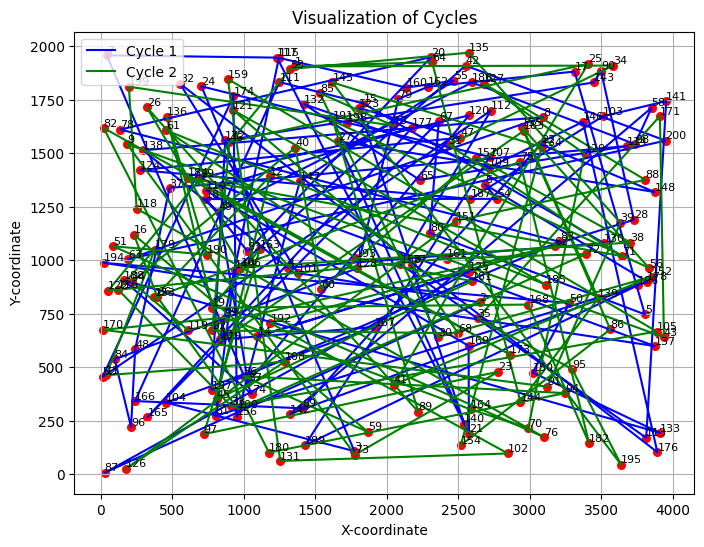

Best length for kroA200.tsp using local_search_steepest is: 320678.26359759946


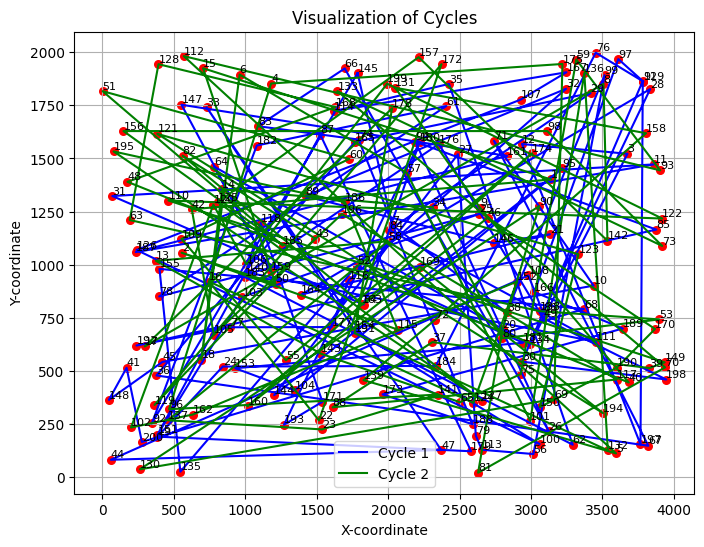

Best length for kroB200.tsp using local_search_steepest is: 312225.9016548394


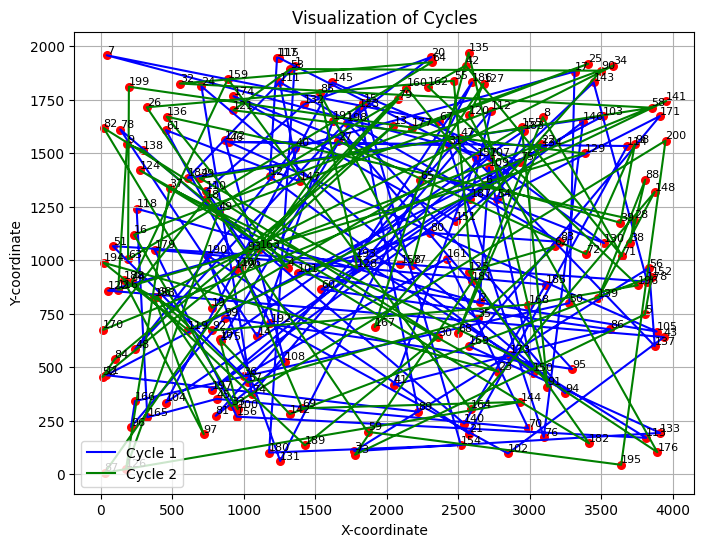

Best length for kroA200.tsp using candidate_moves_algorithm is: 313385.03632124


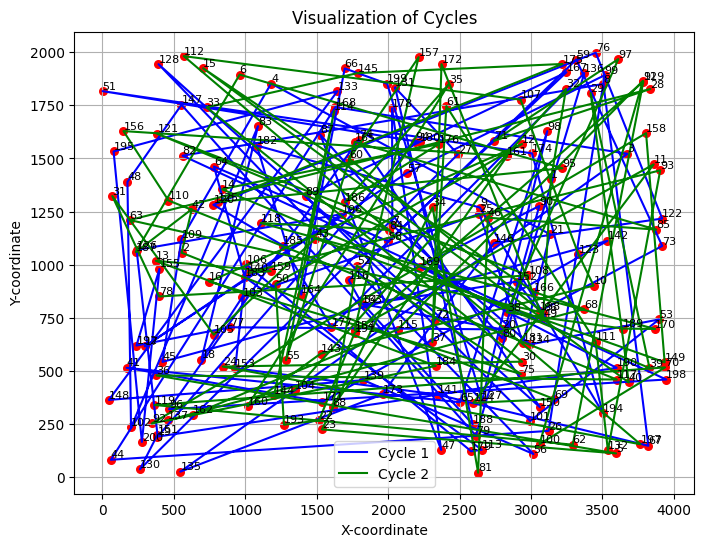

Best length for kroB200.tsp using candidate_moves_algorithm is: 312976.49648413685


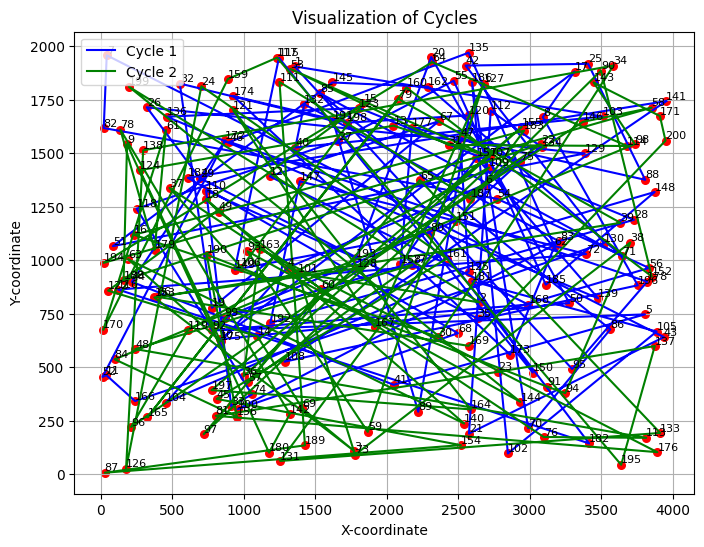

Best length for kroA200.tsp using cache_moves_algorithm is: 322342.3647242598


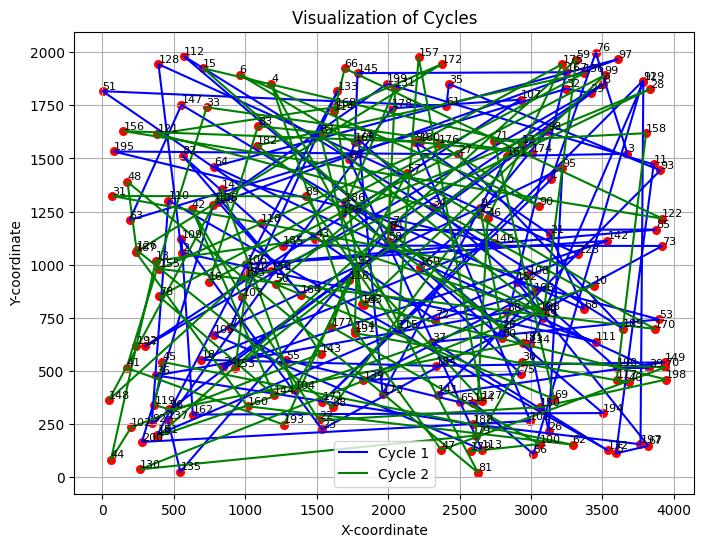

Best length for kroB200.tsp using cache_moves_algorithm is: 310006.52565426374


In [246]:
instances = ['kroA200.tsp', 'kroB200.tsp']
functions = [local_search_steepest, candidate_moves_algorithm, cache_moves_algorithm]

for f in functions:
    for instance in instances:
        best_length = 0
        best_cycles = None
        for i in range(20):

            FILENAME = instance

            data = read_data_file(FILENAME)
            distance = calculate_distance_matrix(data)
            random_cycle1, random_cycle2 = random_cycle(get_nodes(data))
            
            start = time.time()
            # c1, c2 = f(random_cycle1, random_cycle2, distance)
            c1, c2 = random_cycle1, random_cycle2
            end = time.time()
            
            final_length = calculate_cycles_length(c1, c2, distance)
            if final_length < best_length or best_length == 0:
                best_length = final_length
                best_cycles = (c1, c2)


            with open('results.csv', 'a') as file:
                file.write(f"{instance};{i};{f.__name__};{final_length};{end-start}\n")
        
        plot_cycles(best_cycles[0], best_cycles[1], data)
        print(f"Best length for {instance} using {f.__name__} is: {best_length}")

In [242]:
import pandas as pd

In [243]:
results = pd.read_csv('results.csv', sep=';', header=None)
results.columns = ['Instancja', 'Iteration', 'Algorytm', 'Długość cyklu', 'Czas wykonania']
results['Długość cyklu'] = results['Długość cyklu'].astype(float)
results['Czas wykonania'] = results['Czas wykonania'].astype(float)
results.drop('Iteration', axis=1, inplace=True)

results_without_time = results.drop('Czas wykonania', axis=1)
results_without_length = results.drop('Długość cyklu', axis=1)

In [244]:
stats = results_without_time.groupby(['Instancja', 'Algorytm']).agg(['min', 'mean', 'max'])


stats = stats.round({('Length', 'min'): 2, ('Length', 'mean'): 2, ('Length', 'max'): 2, 
                     ('Time', 'min'): 4, ('Time', 'mean'): 4, ('Time', 'max'): 4})
stats

Długość cyklu                \
                                                min          mean   
Instancja   Algorytm                                                
kroA200.tsp cache_moves_algorithm      46460.374788  51170.044745   
            candidate_moves_algorithm  42479.010146  46868.385160   
            local_search_steepest      37402.709398  39865.420141   
kroB200.tsp cache_moves_algorithm      46727.067879  51099.903713   
            candidate_moves_algorithm  44043.445136  46479.567487   
            local_search_steepest      37046.046442  39829.242479   

                                                     
                                                max  
Instancja   Algorytm                                 
kroA200.tsp cache_moves_algorithm      57510.783691  
            candidate_moves_algorithm  50665.481352  
            local_search_steepest      42287.448817  
kroB200.tsp cache_moves_algorithm      57312.229788  
            candidate_moves_algorithm  49834.288120  
            local_search_steepest      42067.887735

In [245]:
stats = results_without_length.groupby(['Instancja', 'Algorytm']).agg(['min', 'mean', 'max'])


stats = stats.round({('Length', 'min'): 2, ('Length', 'mean'): 2, ('Length', 'max'): 2, 
                     ('Time', 'min'): 4, ('Time', 'mean'): 4, ('Time', 'max'): 4})

stats

Czas wykonania                      
                                                 min       mean        max
Instancja   Algorytm                                                      
kroA200.tsp cache_moves_algorithm           1.552162   3.070065   9.835733
            candidate_moves_algorithm       4.056581   6.391254  17.287575
            local_search_steepest           8.935561  13.918775  36.904480
kroB200.tsp cache_moves_algorithm           1.382690   2.981271   8.683998
            candidate_moves_algorithm       4.090780   6.337875  16.803100
            local_search_steepest           8.634407  13.565181  34.762545